# **Final Project Task 4 - Census Modeling Clustering**

Requirements:

Load Data
- Use the preprocessed dataset from Task 1.

Prepare Features
- Feature Selection:
    - Select relevant numerical and categorical features.
    - Note: K-Means works best with numerical data.
- Data Preprocessing:
    - Be sure you have normalized numerical features (e.g., using MinMaxScaler or StandardScaler) and categorical features encoded properly (e.g., One-Hot Encoding or Ordinal Encoding).
    
Clustering Model Implementation
- Apply K-Means Clustering:
    - Experiment with different values of K (number of clusters).
    - Use the Elbow Method to determine the optimal number of clusters:
    - Use yellowbrick.cluster.KElbowVisualizer to find the best K.
    - Calculate the Silhouette Score to evaluate cluster separation.
- Alternative Clustering Approaches:
    - Experiment with Hierarchical Clustering.
    - Experiment with DBSCAN

Visualize & Interpret Clusters
- Dimensionality Reduction:
    - Apply PCA or t-SNE to reduce dimensions and visualize clusters in 2D.
- Cluster Analysis:
    - Plot the clusters in 2D space.
    - Identify key characteristics of each group.
    - Use only numerical variables to interpret the clusters.
- Example insights:
    - "Older individuals tend to work fewer hours per week."
    - "High-income individuals belong to a specific cluster."

Evaluate Cluster Quality
- Silhouette Score:
    - Compute the Silhouette Score to measure cluster compactness and separation. Higher values indicate better clustering results.
- Cluster Distribution:
    - Analyze how well the data points are distributed across clusters.


Deliverables:
- Notebook code with no errors.
- Visualizations & Analysis:
- Elbow method plot for K selection.
- 2D visualization of clusters.
- Summary of cluster characteristics.
- Cluster evaluation metrics (Silhouette Score).






In [ ]:
import pandas as pd

In [ ]:
data_url = "https://archive.ics.uci.edu/ml/machine-learning-databases/adult/adult.data"
columns = [
    "age", "workclass", "fnlwgt", "education", "education-num", "marital-status",
    "occupation", "relationship", "race", "sex", "capital-gain", "capital-loss",
    "hours-per-week", "native-country", "income"
]

data = pd.read_csv(data_url, header=None, names=columns, na_values=" ?", skipinitialspace=True)
data.sample(10)

In [ ]:
# Example of using KElbowVisualizer

# from yellowbrick.cluster import KElbowVisualizer
# visualizer = KElbowVisualizer(clustering_model, k=(2, 10), metric='distortion', timings=False)
# visualizer.fit(preprocessed_data)
# visualizer.show()
# optimal_k = visualizer.elbow_value_


# Example of using PCA

# from sklearn.decomposition import PCA
# clusters = clustering_model.fit_predict(preprocessed_data)
# pca = PCA(n_components=2)
# pca_result = pca.fit_transform(preprocessed_data)
# pca1 = pca_result[:, 0]
# pca2 = pca_result[:, 1]
# # Visualizing Clusters
# plt.figure(figsize=(10, 6))
# sns.scatterplot(x=pca1, y=pca2, hue=clusters, palette='tab10', data=data, alpha=0.7)
# plt.title(f'PCA Projection of Clusters (K={num_clusters})')
# plt.xlabel('Principal Component 1')
# plt.ylabel('Principal Component 2')
# plt.legend(title='Cluster')
# plt.show()

Feature matrix shape: (32561, 104) (numeric-only)


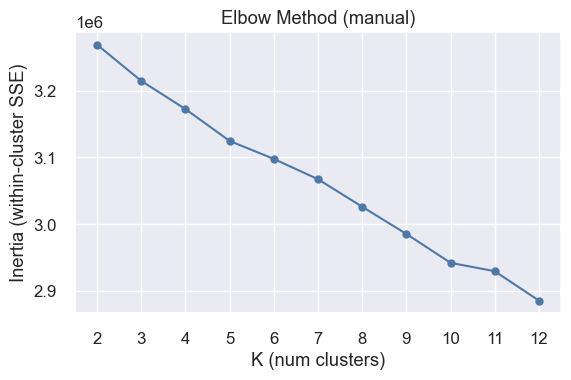

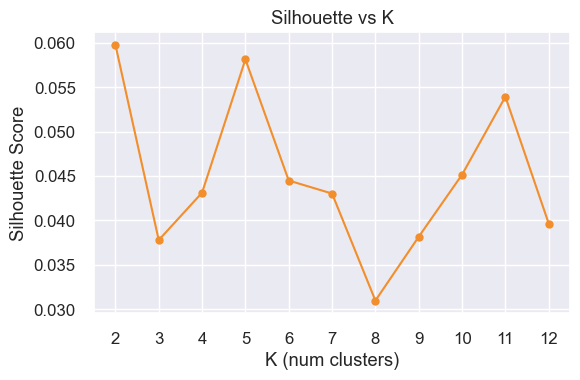

Yellowbrick not available or failed; proceeding with manual selection.
Best K by silhouette: 2; Final K used: 2
K-Means silhouette (K=2): 0.0598


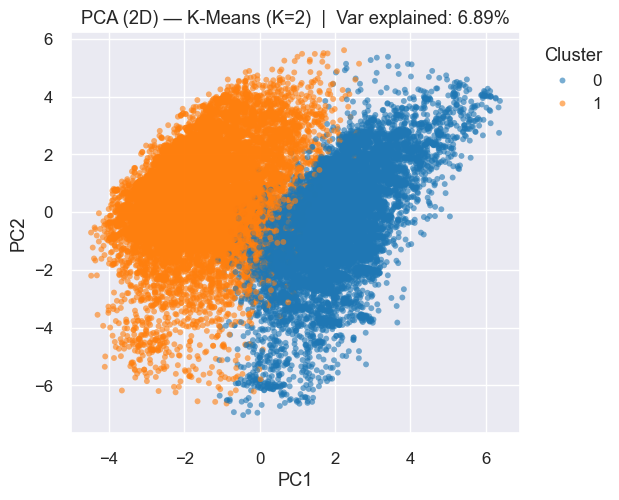

,age,fnlwgt,education-num,capital-gain,capital-loss,capital-net,is_married,workclass_Federal-gov,workclass_Local-gov,workclass_Never-worked,...,native-country_Taiwan,native-country_Thailand,native-country_Trinadad&Tobago,native-country_United-States,native-country_Vietnam,native-country_Yugoslavia,age_group_adult,age_group_mid-age,age_group_senior,n_points
cluster,,,,,,,,,,,,,,,,,,,,,
0,0.351826,-0.028880,0.099286,0.165654,0.090694,0.148943,1.045700,0.012549,0.014477,-0.010171,...,0.007115,-0.003872,0.000427,-0.013599,-0.010471,0.013564,0.092585,0.223696,0.042605,15145
1,-0.305949,0.025114,-0.086339,-0.144053,-0.078868,-0.129521,-0.909343,-0.010913,-0.012589,0.008845,...,-0.006187,0.003367,-0.000371,0.011826,0.009106,-0.011795,-0.080512,-0.194526,-0.037050,17416


Top variables that differentiate clusters:
['marital-status_Married-civ-spouse', 'is_married', 'marital-status_Never-married', 'relationship_Not-in-family', 'sex_Male', 'relationship_Own-child', 'age', 'relationship_Unmarried', 'relationship_Wife', 'age_group_mid-age']


,count,mean,median,std
cluster,,,,
0,15130,40.87,40.0,12.45
1,17407,40.07,40.0,12.25


Agglomerative (ward, K=2) silhouette: 0.4886


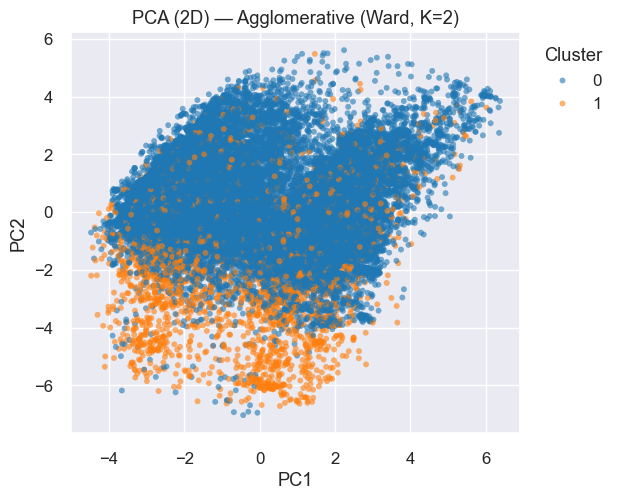

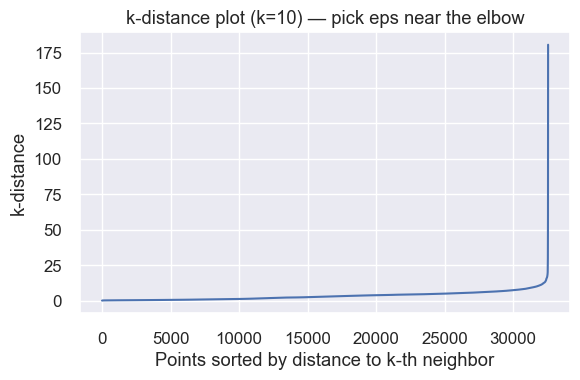

DBSCAN found 119 clusters and 8194 noise points (eps=4.325, min_samples=10)
DBSCAN silhouette (excluding noise): 0.1243


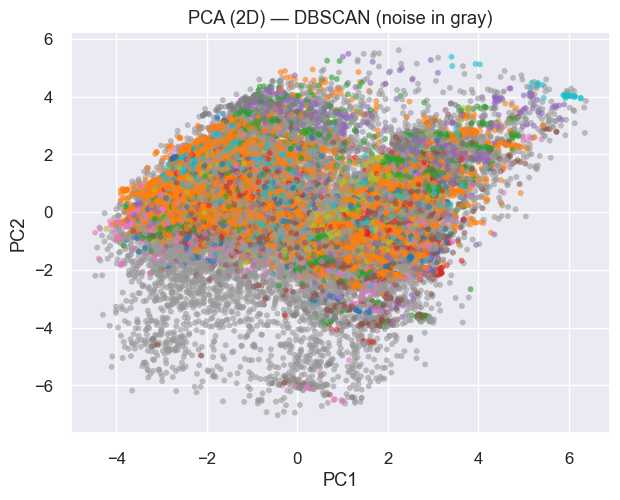

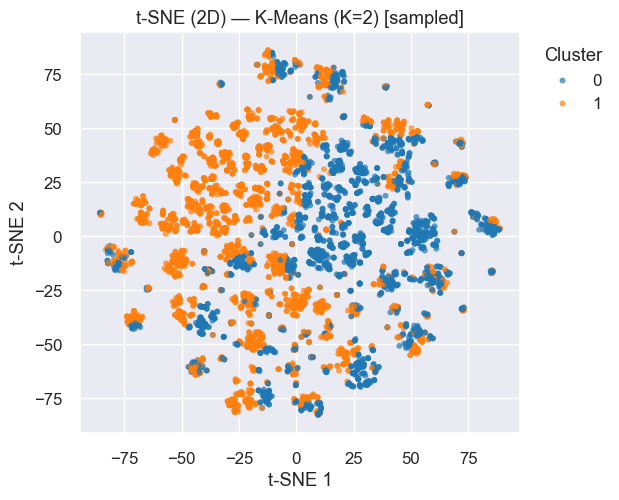


=== Cluster Evaluation Summary ===
K-Means (K=2) silhouette: 0.0598
Agglomerative (K=2) silhouette: 0.4886
DBSCAN clusters: 119 (silhouette: 0.12425635151690143)

Cluster sizes (K-Means):
0    15145
1    17416
Name: count, dtype: int64


In [3]:

# %% Imports & setup
import os
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns

from pathlib import Path

from sklearn.preprocessing import StandardScaler, MinMaxScaler
from sklearn.cluster import KMeans, AgglomerativeClustering, DBSCAN
from sklearn.decomposition import PCA
from sklearn.metrics import silhouette_score
from sklearn.neighbors import NearestNeighbors

plt.style.use("seaborn-v0_8")
sns.set(font_scale=1.1)
Path("figs_task4").mkdir(exist_ok=True)

RANDOM_STATE = 42
np.random.seed(RANDOM_STATE)

# %% Load preprocessed dataset
DATA_PATH = "adult_preprocessed.csv"
assert os.path.exists(DATA_PATH), "adult_preprocessed.csv not found. Please run Task 1 first."

df = pd.read_csv(DATA_PATH)
assert "hours-per-week" in df.columns, "Target column 'hours-per-week' not found in preprocessed data."

# Separate target for post-hoc analysis; exclude from clustering features
target = "hours-per-week"
y_target = df[target].copy()

# Drop supervised target & any income dummies from features (to keep clustering unsupervised)
income_like = [c for c in df.columns if c.lower().startswith("income")]
feature_df = df.drop(columns=[target] + income_like, errors="ignore")

# Sanity: ensure numeric only (preprocessed data should be numeric already)
numeric_cols = feature_df.select_dtypes(include=[np.number]).columns.tolist()
X = feature_df[numeric_cols].copy()

# Replace infs → NaN, then impute with 0.0 (consistent with prior tasks)
X.replace([np.inf, -np.inf], np.nan, inplace=True)
if X.isna().any().any():
    X = X.fillna(0.0)

print(f"Feature matrix shape: {X.shape} (numeric-only)")

# Re-scale features for clustering (K-Means sensitive to scale)
# If your Task 1 already standardized, this is harmless; keeps consistent scale.
scaler = StandardScaler()
X_scaled = pd.DataFrame(scaler.fit_transform(X), columns=X.columns, index=X.index)

# %% K-Means: Elbow & Silhouette across K
k_values = list(range(2, 13))  # 2..12
inertias, silhouettes = [], []

for k in k_values:
    km = KMeans(n_clusters=k, n_init=10, random_state=RANDOM_STATE)
    labels_k = km.fit_predict(X_scaled)
    inertias.append(km.inertia_)
    sil = silhouette_score(X_scaled, labels_k)
    silhouettes.append(sil)

# 1) Manual Elbow plot
plt.figure(figsize=(6,4))
plt.plot(k_values, inertias, marker="o", color="#4e79a7")
plt.xlabel("K (num clusters)"); plt.ylabel("Inertia (within-cluster SSE)")
plt.title("Elbow Method (manual)")
plt.xticks(k_values)
plt.tight_layout(); plt.savefig("figs_task4/01_elbow_manual.png", dpi=140); plt.show()

# 2) Silhouette vs K
plt.figure(figsize=(6,4))
plt.plot(k_values, silhouettes, marker="o", color="#f28e2b")
plt.xlabel("K (num clusters)"); plt.ylabel("Silhouette Score")
plt.title("Silhouette vs K")
plt.xticks(k_values)
plt.tight_layout(); plt.savefig("figs_task4/02_silhouette_vs_k.png", dpi=140); plt.show()

# 3) Yellowbrick KElbowVisualizer (optional; fallback if not installed)
try:
    from yellowbrick.cluster import KElbowVisualizer
    km = KMeans(n_init=10, random_state=RANDOM_STATE)
    viz = KElbowVisualizer(km, k=(2, 12), metric="distortion", timings=False)
    viz.fit(X_scaled)
    viz.show(outpath="figs_task4/03_elbow_yellowbrick.png")
    print(f"Yellowbrick suggested K: {viz.elbow_value_}")
    suggested_k = int(viz.elbow_value_) if viz.elbow_value_ is not None else None
except Exception as e:
    print("Yellowbrick not available or failed; proceeding with manual selection.")
    suggested_k = None

# Choose best K by highest silhouette (tie-breaker: smallest K)
best_k_by_sil = int(k_values[int(np.argmax(silhouettes))])
final_k = suggested_k or best_k_by_sil
print(f"Best K by silhouette: {best_k_by_sil}; Final K used: {final_k}")

# Fit final K-Means
kmeans_final = KMeans(n_clusters=final_k, n_init=10, random_state=RANDOM_STATE)
labels_kmeans = kmeans_final.fit_predict(X_scaled)
sil_kmeans = silhouette_score(X_scaled, labels_kmeans)
print(f"K-Means silhouette (K={final_k}): {sil_kmeans:.4f}")

# %% PCA 2D visualization for K-Means clusters
pca = PCA(n_components=2, random_state=RANDOM_STATE)
X_pca = pca.fit_transform(X_scaled)
explained = pca.explained_variance_ratio_.sum()

plt.figure(figsize=(6.4, 5.2))
palette = sns.color_palette("tab10", n_colors=final_k)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_kmeans, palette=palette, s=18, linewidth=0, alpha=0.6)
plt.title(f"PCA (2D) — K-Means (K={final_k})  |  Var explained: {explained:.2%}")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend(title="Cluster", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout(); plt.savefig("figs_task4/04_pca_kmeans.png", dpi=140); plt.show()

# %% Cluster profiling (numeric-only variables)
# Mean profile by cluster, plus size
profile = pd.DataFrame(X_scaled).copy()
profile["cluster"] = labels_kmeans
cluster_profile = profile.groupby("cluster").mean().copy()
cluster_profile["n_points"] = profile["cluster"].value_counts().sort_index().values
display(cluster_profile.head())

cluster_profile.to_csv("figs_task4/cluster_profile_kmeans.csv")

# For interpretation, show top variables that differ the most between clusters
std_across_clusters = cluster_profile.drop(columns=["n_points"]).std(axis=0).sort_values(ascending=False)
top_diff_vars = std_across_clusters.head(10).index.tolist()
print("Top variables that differentiate clusters:")
print(top_diff_vars)

# Post-hoc: how does the target distribute by cluster (not used for clustering)
posthoc = pd.DataFrame({"cluster": labels_kmeans, target: y_target})
posthoc_summary = posthoc.groupby("cluster")[target].agg(["count", "mean", "median", "std"]).round(2)
display(posthoc_summary)

posthoc_summary.to_csv("figs_task4/posthoc_target_by_cluster.csv")

# %% Alternative 1 — Hierarchical Clustering (Agglomerative, Ward linkage)
from sklearn.cluster import AgglomerativeClustering
from sklearn.metrics import silhouette_score

# For ward linkage, Euclidean is implicit and the only valid metric
agg = AgglomerativeClustering(n_clusters=final_k, linkage="ward")
labels_agg = agg.fit_predict(X_scaled)
sil_agg = silhouette_score(X_scaled, labels_agg)
print(f"Agglomerative (ward, K={final_k}) silhouette: {sil_agg:.4f}")

# Reuse the PCA transform you already computed (X_pca)
plt.figure(figsize=(6.4, 5.2))
palette = sns.color_palette("tab10", n_colors=final_k)
sns.scatterplot(x=X_pca[:,0], y=X_pca[:,1], hue=labels_agg, palette=palette,
                s=18, linewidth=0, alpha=0.6)
plt.title(f"PCA (2D) — Agglomerative (Ward, K={final_k})")
plt.xlabel("PC1"); plt.ylabel("PC2"); plt.legend(title="Cluster", bbox_to_anchor=(1.02, 1), loc="upper left")
plt.tight_layout(); plt.savefig("figs_task4/05_pca_agg.png", dpi=140); plt.show() 

# %% Alternative 2 — DBSCAN
# Heuristic k-distance plot (k = min_samples)
min_samples = 10
nn = NearestNeighbors(n_neighbors=min_samples)
nn.fit(X_scaled)
dists, idxs = nn.kneighbors(X_scaled)
k_dists = np.sort(dists[:, -1])  # distance to kth neighbor

plt.figure(figsize=(6,4))
plt.plot(k_dists)
plt.title(f"k-distance plot (k={min_samples}) — pick eps near the elbow")
plt.xlabel("Points sorted by distance to k-th neighbor"); plt.ylabel("k-distance")
plt.tight_layout(); plt.savefig("figs_task4/06_kdist_dbscan.png", dpi=140); plt.show()

# Simple heuristic for eps: median k-distance * factor
eps = float(np.median(k_dists) * 1.5)
db = DBSCAN(eps=eps, min_samples=min_samples, n_jobs=-1)
labels_db = db.fit_predict(X_scaled)

n_noise = int(np.sum(labels_db == -1))
n_clusters_db = len(set(labels_db)) - (1 if -1 in labels_db else 0)
print(f"DBSCAN found {n_clusters_db} clusters and {n_noise} noise points (eps={eps:.3f}, min_samples={min_samples})")

# DBSCAN silhouette only if >=2 clusters
if n_clusters_db >= 2:
    sil_db = silhouette_score(X_scaled[labels_db!=-1], labels_db[labels_db!=-1])
    print(f"DBSCAN silhouette (excluding noise): {sil_db:.4f}")
else:
    sil_db = np.nan
    print("DBSCAN silhouette not defined (clusters < 2).")

# Visualize DBSCAN on PCA
plt.figure(figsize=(6.4, 5.2))
palette = sns.color_palette("tab10", n_colors=max(n_clusters_db, 1)+1)
# Map -1 (noise) to a gray color
colors = np.array([palette[l % len(palette)] if l >= 0 else (0.6,0.6,0.6) for l in labels_db])
plt.scatter(X_pca[:,0], X_pca[:,1], c=colors, s=18, alpha=0.6, linewidths=0)
plt.title("PCA (2D) — DBSCAN (noise in gray)")
plt.xlabel("PC1"); plt.ylabel("PC2")
plt.tight_layout(); plt.savefig("figs_task4/07_pca_dbscan.png", dpi=140); plt.show()

# %% (Optional) t-SNE 2D for K-Means clusters — run on a sample for speed
try:
    from sklearn.manifold import TSNE
    SAMPLE = min(6000, len(X_scaled))  # keep it fast
    sample_idx = np.random.choice(len(X_scaled), size=SAMPLE, replace=False)
    X_sample = X_scaled.iloc[sample_idx]
    labels_sample = labels_kmeans[sample_idx]

    tsne = TSNE(n_components=2, learning_rate="auto", init="pca", random_state=RANDOM_STATE, perplexity=30)
    X_tsne = tsne.fit_transform(X_sample)

    plt.figure(figsize=(6.4, 5.2))
    palette = sns.color_palette("tab10", n_colors=final_k)
    sns.scatterplot(x=X_tsne[:,0], y=X_tsne[:,1], hue=labels_sample, palette=palette, s=18, linewidth=0, alpha=0.7)
    plt.title(f"t-SNE (2D) — K-Means (K={final_k}) [sampled]")
    plt.xlabel("t-SNE 1"); plt.ylabel("t-SNE 2"); plt.legend(title="Cluster", bbox_to_anchor=(1.02, 1), loc="upper left")
    plt.tight_layout(); plt.savefig("figs_task4/08_tsne_kmeans.png", dpi=140); plt.show()
except Exception as e:
    print("t-SNE skipped (not available or failed):", e)

# %% Evaluation summary & printout
print("\n=== Cluster Evaluation Summary ===")
print(f"K-Means (K={final_k}) silhouette: {sil_kmeans:.4f}")
print(f"Agglomerative (K={final_k}) silhouette: {sil_agg:.4f}")
print(f"DBSCAN clusters: {n_clusters_db} (silhouette: {sil_db if not np.isnan(sil_db) else 'NA'})")

print("\nCluster sizes (K-Means):")
print(pd.Series(labels_kmeans).value_counts().sort_index())

Task 4 — Clustering Summary

K‑Means on standardized numeric features identified K=2 as the best K by the silhouette method. However, the silhouette score is low (0.06), indicating weak separation in the high‑dimensional space. The two clusters differ primarily by marital status, household relationship roles, sex, and age — consistent with the dataset’s demographics — while hours‑per‑week remains very similar across clusters (means ~40.1 vs ~40.9; medians both 40).

Agglomerative clustering (Ward) with K=2 produced a higher silhouette (~0.49), suggesting tighter within-cluster variance in the encoded feature space. Nevertheless, post‑hoc analysis of the target reveals minimal practical separation in working hours between the groups.
DBSCAN (with a heuristic eps) yielded many small clusters and a large noise set; the silhouette (on non-noise points) was 0.12. This indicates that density-based partitions are unstable on this standardized, high‑dimensional mix of engineered/dummy variables without careful parameter tuning (and likely dimensionality reduction first).


Conclusion. Clustering reveals clear demographic groupings (marital status, relationship roles, sex, age), but these do not translate into meaningful differences in the target hours‑per‑week. This aligns with previous EDA/modeling: the target is dominated by a 40‑hour mode with limited structure explained by features. K‑Means with K=2 is acceptable as a compact segmentation of demographics; for interpretability, the cluster profile table highlights which variables differ the most across groups.